In [41]:
import osmnx as ox
import pandas as pd
import geopandas as gd
import networkx as nx
from scgraph.geographs.marnet import marnet_geograph
from shapely import geometry

In [42]:
ox.settings.bidirectional_network_types = ["drive"]

my_tags = {'industrial' : 'port', 
        'aeroway' : ['aerodrome','heliport', 'airstrip'], 
        'landuse' : 'railway', 
        'building' : 'warehouse', 'amenity' : 'mailroom'}

# point_y = (60.18742, 57.52054)
# point_x = (29.72461, 41.21192)
point_y = (59.46406, 59.27374)
point_x = (24.11719, 25.43555)

''' Построение датафрейма нужных фич '''
def func_tags(m_tags, point_y, point_x):

    try:
        gdf = ox.features.features_from_bbox(bbox = (max(point_y), min(point_y), min(point_x), max(point_x)), tags = m_tags).reset_index()
        gdf = gdf[['element_type', 'osmid']]
        gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)

        list_lat_lon = []
        for i in range(gdf.n_osmid.shape[0]):
            try:
                bb = ox.geocode_to_gdf(gdf.n_osmid.iloc[i], by_osmid=True)[['lat', 'lon']]
                list_lat_lon.append(bb.iloc[:])
            except ox._errors.InsufficientResponseError:
                list_lat_lon.append(pd.DataFrame({'lat': [None], 'lon': [None]}))
        dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
        gdf = gdf.merge(dfs, on=dfs.index).drop('key_0', axis=1)
        gdf = gdf[['lat', 'lon']]
        gdf['kind_of'] = list(m_tags.keys())[0]
        gdf = gdf.dropna().reset_index(drop=True)
        return gdf
    except ox._errors.InsufficientResponseError:
        return None
    

''' Построение графа, получение датафрейма фич и получение датафрейма долгот и широт для дальшейших вычислений '''
def create_graph_city(point_y, point_x, my_network_type = None, my_filter = None):
    full_df = func_tags(my_tags, point_y, point_x)
    G = ox.graph_from_bbox(bbox = (max(point_y), min(point_y), min(point_x), max(point_x)), 
                           retain_all=True, simplify = True, network_type = my_network_type, custom_filter = my_filter)

    lat = list(full_df['lat'].values)
    lon = list(full_df['lon'].values)

    return full_df, G, lat, lon


''' Формирование датафрейма фич '''
def create_features_city(features_df, city_graph, lat, lon):
    features_df['new_nodes'] = ox.distance.nearest_nodes(city_graph, lon, lat)
    return features_df


''' Создание датафрейма со всеми маршрутами '''
def create_graph_route(input_graph, f_df):
    one_route = []
    for i in range(f_df.shape[0]):
        for j in range(i + 1, f_df.shape[0]):
            try:
                one_route.append(nx.shortest_path(input_graph, f_df['new_nodes'].iloc[i], f_df['new_nodes'].iloc[j]))
            except nx.NetworkXNoPath:
                pass
    route_df = pd.DataFrame({'route' : one_route})
    return route_df


''' Создание из нескольких LineString один MultiLineString - нужно для финального графа '''
def create_gdf_graph(nn, ee):
    ii = 0
    list_line = []
    list_multi_line = []
    for i in range(nn.shape[0] - 1):
        idx = nn.iloc[i + 1].new_nodes
        for j in range(ii, ee.index.get_level_values('u').shape[0]):
            if ee.index.get_level_values('u')[j] != idx:
                for k in range(len(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values)):
                    list_line.append(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values[k])
            else : 
                ii = j
        multi_line = geometry.MultiLineString(list_line)
        list_line = []
        list_multi_line.append(multi_line)
    return list_multi_line


''' Построение финального графа путей '''
def create_final_graph(arb_graph, route_df, feature_df):
    list_graphs = []
    for i in range(route_df.route.shape[0]):
        r = route_df['route'].values[i]

        rr = pd.DataFrame({'new_nodes' : r})
        rr['osmid'] = rr['new_nodes']
        rr = rr.set_index('osmid')
        rr['x'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['x'])
        rr['y'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['y'])
        rr

        edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

        graph_attrs = {"crs": "WGS84"}
        multi_digraph_aero = ox.convert.graph_from_gdfs(
            rr, edge_gdf, graph_attrs=graph_attrs)
        
        list_graphs.append(multi_digraph_aero)
        
    my_graph = list_graphs[0]
    for i in range(1, len(list_graphs)):
        my_graph = nx.compose_all([my_graph, list_graphs[i]])

    nodes, edges = ox.graph_to_gdfs(my_graph)
    list_nodes = list(feature_df['new_nodes'].values)
    n = nodes[nodes['new_nodes'].isin(list_nodes)]

    list_multiline = create_gdf_graph(n, edges)
    edge_dict = {'u': n.new_nodes[:-1].values, 'v': n.new_nodes[1:].values, 'key': 0}
    edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
    edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])
    edge_gdf['geometry'] = list_multiline
    graph_attrs = {"crs": "WGS84"}
    multi_digraph = ox.graph_from_gdfs(
        n, edge_gdf, graph_attrs=graph_attrs)
    
    return multi_digraph

In [43]:
def result(point_y, point_x):
    graph_city = create_graph_city(point_y, point_x, my_network_type = 'drive')
    feature_df = create_features_city(*graph_city)
    ox.distance.add_edge_lengths(graph_city[1], edges=None)
    route_df = create_graph_route(graph_city[1], feature_df)
    final_graph_1_drive = create_final_graph(graph_city[1], route_df, feature_df)
    return final_graph_1_drive

___

C:\Users\orenc\AppData\Local\Temp\ipykernel_6120\2538801726.py:17: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  gdf = ox.features.features_from_bbox(bbox = (max(point_y), min(point_y), min(point_x), max(point_x)), tags = m_tags).reset_index()
C:\Users\orenc\AppData\Local\Temp\ipykernel_6120\2538801726.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\orenc\AppData\Local\Temp\ipykernel_6120\2538801726.py:41: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(bbox = (max(point_y), min(point_

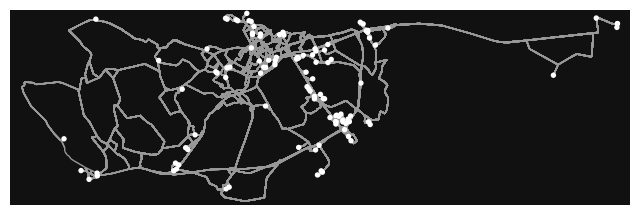

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [44]:
res_3 = result(point_y, point_x)
ox.plot_graph(res_3)

In [45]:
nodes_3, edges_3 = ox.graph_to_gdfs(res_3)
nodes_3.to_csv('data/nodes_points.csv')
edges_3.to_csv('data/edges_points.csv')

In [46]:
metrics_1 = nx.degree_centrality(res_3)
metrics_2 = nx.closeness_centrality(res_3)
metrics_3 = nx.betweenness_centrality(res_3)
metrics_4 = nx.pagerank(res_3, alpha = 0.8)